# UIUC Grid Demand: Solar Power + Dry Bulb Temperature

This notebook uses an Echo State Network(ESN) (from pyESN) to predict the solar generation at the University of Illinois.
Rather than one input, there are two inputs: Solar Power and Dry Bulb Temp. 
The following items are included:

1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("../data/railsplitter_data.csv", usecols=['Time','MWh'])[:-1]
windpower = np.array(dataframe.MWh).astype('float64')

# normalize
norm = np.linalg.norm(windpower)
windpower_norm = windpower/norm

In [3]:
# start = str(dataframe.Time[0])
start = '11/1/2016'
# end = str(dataframe.Time[len(windpower)-1])
end = '7/1/2019'
print(start, '\n', end)

11/1/2016 
 7/1/2019


In [4]:
feature = 'drytemp'
feature_df = pd.read_csv("../data/champaign_weatherdata.csv", usecols=['time',feature])
feature_df['time'] = pd.to_datetime(feature_df['time'])
mask = (feature_df.time > pd.to_datetime(start)) & (feature_df.time < pd.to_datetime(end))
feature_df = feature_df[mask]

feature_data = np.array(feature_df[feature]).astype('float64')

# normalize
norm_f = np.linalg.norm(feature_data)
feature_norm = feature_data/norm_f

In [5]:
time_range = pd.date_range(start='11/1/2016', end='7/1/2019', freq='h')[:len(windpower)]
elevation = generate_elevation_series(time_range, timestamps=True)
norm_a = np.linalg.norm(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of demand: {norm}")

Norm of elevation angles: 5528.845712658295
Norm of demand: 608.5900148605791


## Format the Input Data

In [6]:
print(len(angles_norm))
print(len(windpower_norm))
print(len(feature_norm))

23327
23327
23327


In [7]:
X_in = np.concatenate([[windpower_norm, feature_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (3, 23327)


In [8]:
params = {'n_reservoir':1000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':72, 
          'trainlen':8000}

In [9]:
futureTotal = params['future']
time_range = np.array(dataframe.Time)
hour_range = np.arange(0, len(time_range), 1)

## 1. Initial Demonstration


In [10]:
tic = time.perf_counter()

init_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 4.12 seconds
This simulation took 0.07 minutes


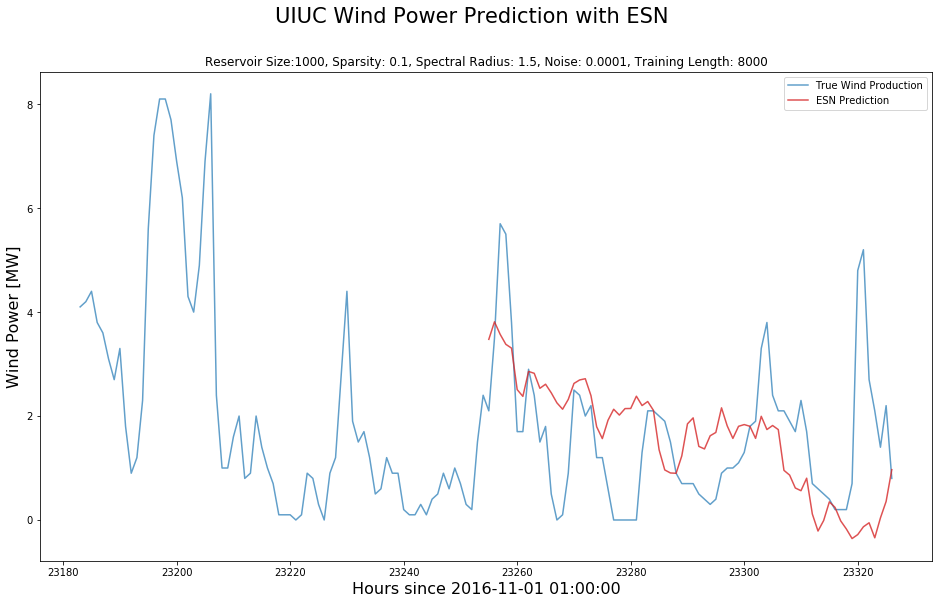

In [11]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*init_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.0028012730875406006
rho = 0.5, noise = 0.0003, MSE=0.0035897871421592805
rho = 0.5, noise = 0.0007, MSE=0.003303044470153135
rho = 0.5, noise = 0.001, MSE=0.0029666098420215903
rho = 0.5, noise = 0.003, MSE=0.0022929160043524575
rho = 0.5, noise = 0.005, MSE=0.0025203131871389876
rho = 0.5, noise = 0.007, MSE=0.0029244979886538683
rho = 0.5, noise = 0.01, MSE=0.00348777192148917
rho = 0.7, noise = 0.0001, MSE=0.002801821569081109
rho = 0.7, noise = 0.0003, MSE=0.0033273355548945793
rho = 0.7, noise = 0.0007, MSE=0.0035678944253182414
rho = 0.7, noise = 0.001, MSE=0.00343139990307838
rho = 0.7, noise = 0.003, MSE=0.0026177703502401535
rho = 0.7, noise = 0.005, MSE=0.0025816942052667544
rho = 0.7, noise = 0.007, MSE=0.00279332742824617
rho = 0.7, noise = 0.01, MSE=0.0032320917937622155
rho = 0.9, noise = 0.0001, MSE=0.0026024367542905845
rho = 0.9, noise = 0.0003, MSE=0.0031958520834072996
rho = 0.9, noise = 0.0007, MSE=0

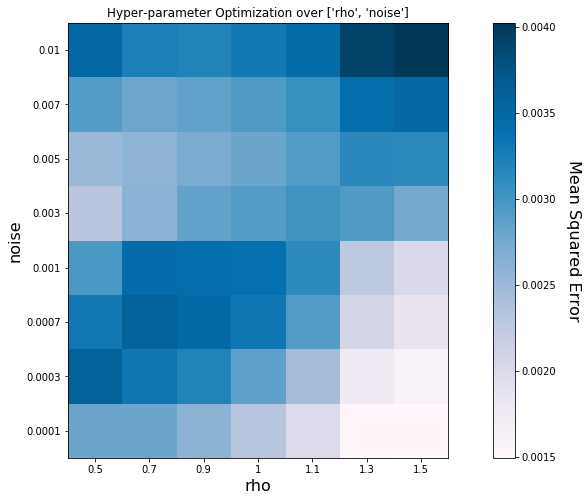

In [12]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(X_in.T,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [13]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1.5 
noise = 0.0001


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.0014290446448939407
n_reservoir = 600, sparsity = 0.01, MSE=0.0013977754255111489
n_reservoir = 600, sparsity = 0.03, MSE=0.0014820862614335706
n_reservoir = 600, sparsity = 0.05, MSE=0.0014272692856537698
n_reservoir = 600, sparsity = 0.1, MSE=0.001383650501943772
n_reservoir = 600, sparsity = 0.15, MSE=0.001507910975181499
n_reservoir = 600, sparsity = 0.2, MSE=0.001376478215745031
n_reservoir = 800, sparsity = 0.005, MSE=0.0013380699938179018
n_reservoir = 800, sparsity = 0.01, MSE=0.0013196071860988319
n_reservoir = 800, sparsity = 0.03, MSE=0.0013070855105869429
n_reservoir = 800, sparsity = 0.05, MSE=0.001275232351672916
n_reservoir = 800, sparsity = 0.1, MSE=0.0012505160130337758
n_reservoir = 800, sparsity = 0.15, MSE=0.0012718204759827427
n_reservoir = 800, sparsity = 0.2, MSE=0.0014751380966654443
n_reservoir = 1000, sparsity = 0.005, MSE=0.0013923919956795685
n_reservoir = 1000, sparsity 

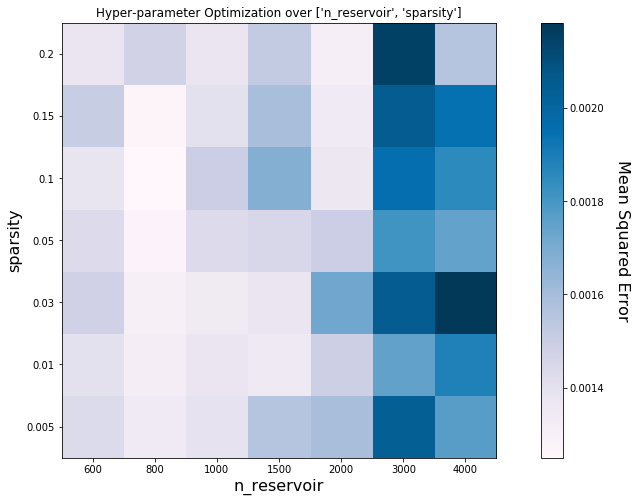

In [14]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(X_in.T,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [15]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 800 
sparsity = 0.1


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

Optimizing over ['trainlen']:
trainlen = 5000, MSE=0.0019132103236760292
trainlen = 5300, MSE=0.0017646060393705168
trainlen = 5600, MSE=0.0017506509136477094
trainlen = 5900, MSE=0.0018117857995644797
trainlen = 6200, MSE=0.0017919963829936387
trainlen = 6500, MSE=0.001723608229704435
trainlen = 6800, MSE=0.0016933020187963126
trainlen = 7100, MSE=0.0014747209904740913
trainlen = 7400, MSE=0.0018235555432423588
trainlen = 7700, MSE=0.001451781511258588
trainlen = 8000, MSE=0.0012505160130337758
trainlen = 8300, MSE=0.001447759640664724
trainlen = 8600, MSE=0.0014512945977402333
trainlen = 8900, MSE=0.0012130469999586785
trainlen = 9200, MSE=0.0016367264185255768
trainlen = 9500, MSE=0.0012613532999374186
trainlen = 9800, MSE=0.0015534542626624256
trainlen = 10100, MSE=0.0013780370202562666
trainlen = 10400, MSE=0.0014966799260921414
trainlen = 10700, MSE=0.0013352808051063376
trainlen = 11000, MSE=0.0013819686043705726
trainlen = 11300, MSE=0.0012421936672252828
trainlen = 11600, MSE=

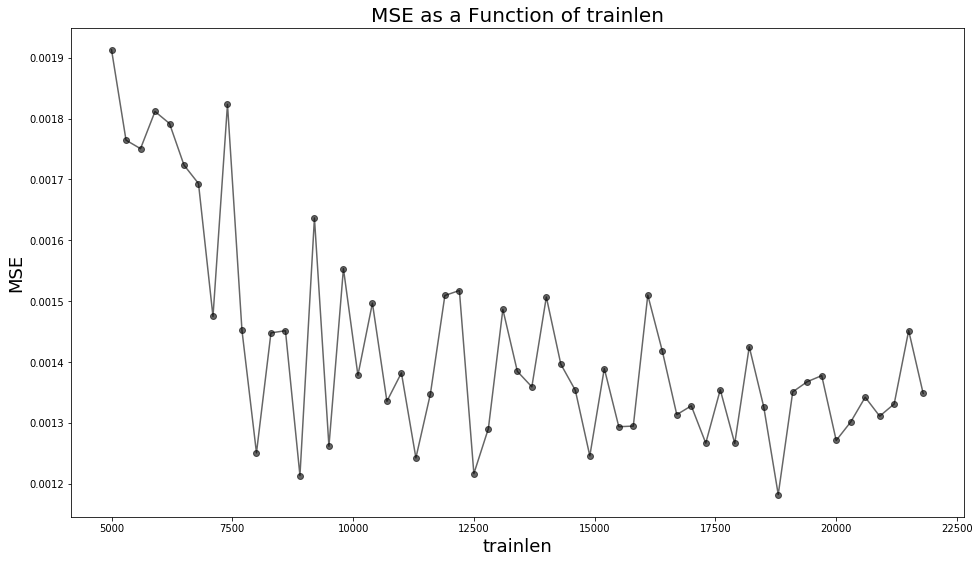

In [17]:
tic = time.perf_counter()
trainingLengths = np.arange(5000,22000,300)
trainlen_loss = grid_optimizer(X_in.T,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [18]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 18800


### 5. Optimized Demand Prediction


In [19]:
tic = time.perf_counter()

opt_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 2.95 seconds
This simulation took 0.05 minutes


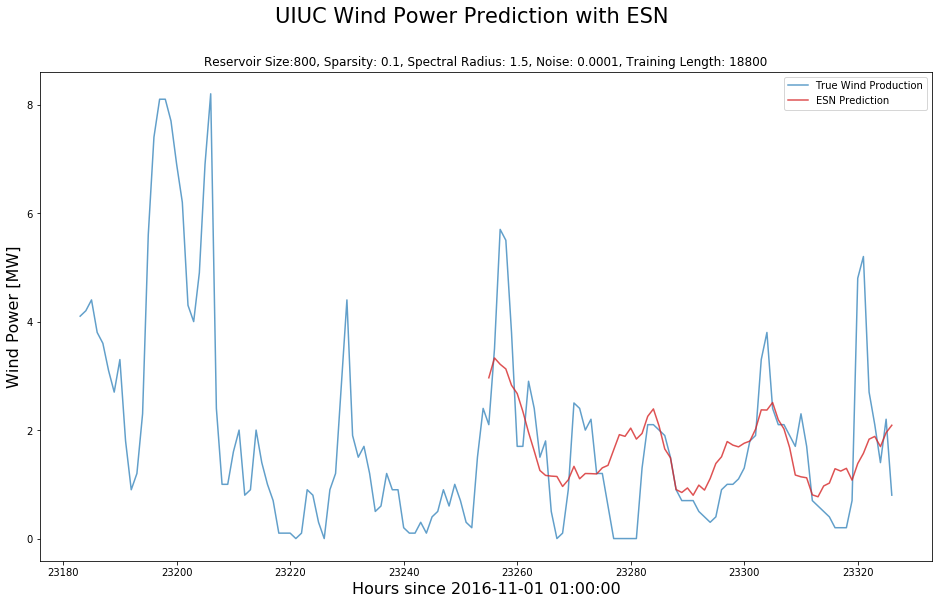

In [20]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 6. Uncertainty Calculation

In [21]:
params = {'n_reservoir':opt_size, 
          'sparsity':opt_sparsity, 
          'rand_seed':85, 
          'rho':opt_radius, 
          'noise':opt_noise, 
          'future':72, 
          'window':72, 
          'trainlen':l_opt}

rand_seeds = [85, 21, 22, 30, 122, 5, 79]

In [22]:
N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 20.87 seconds
This simulation took 0.35 minutes


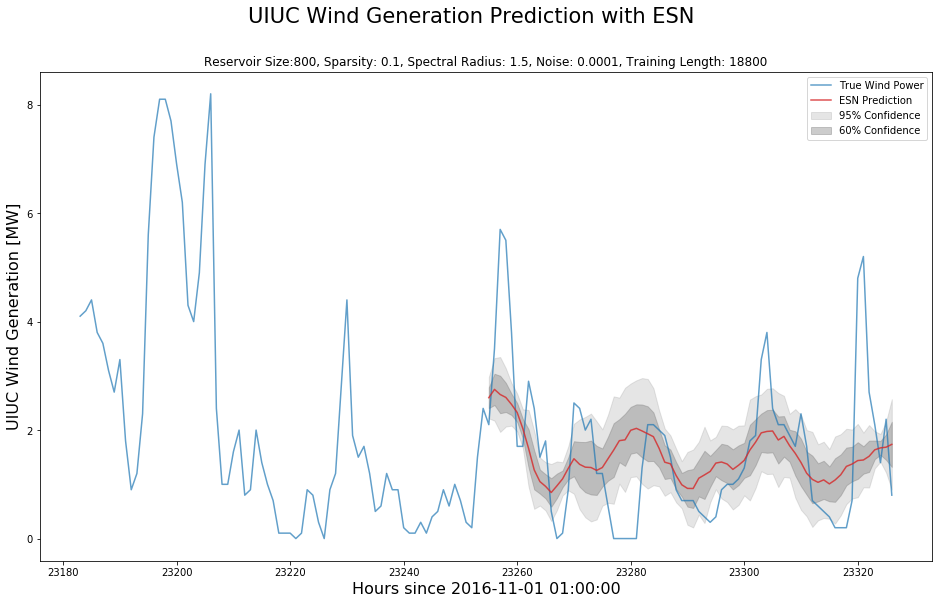

In [23]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Generation Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Wind Generation [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

In [24]:
params['window'] = 12

N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 113.93 seconds
This simulation took 1.90 minutes


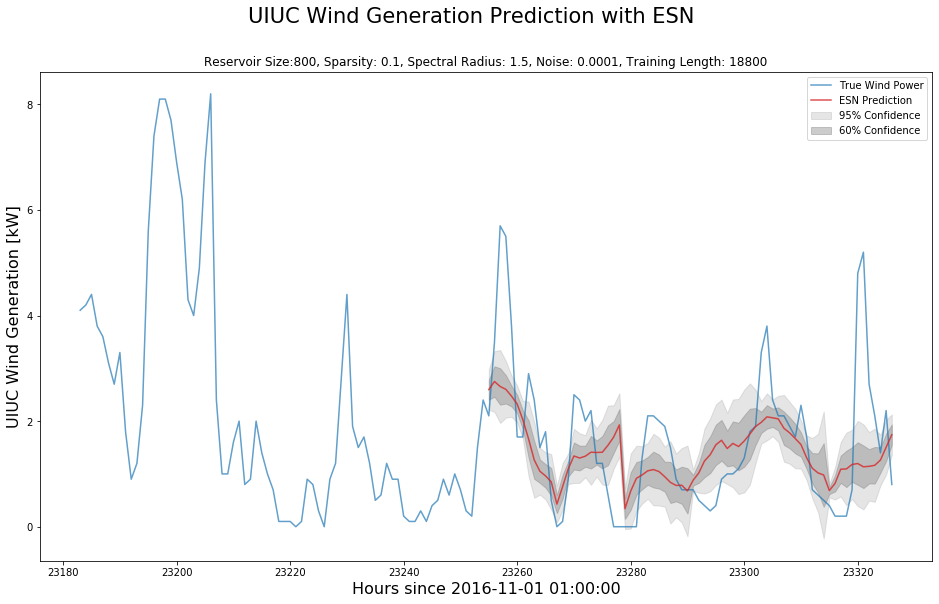

In [25]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Generation Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Wind Generation [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

In [26]:
params['window'] = 1

N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 1368.27 seconds
This simulation took 22.80 minutes


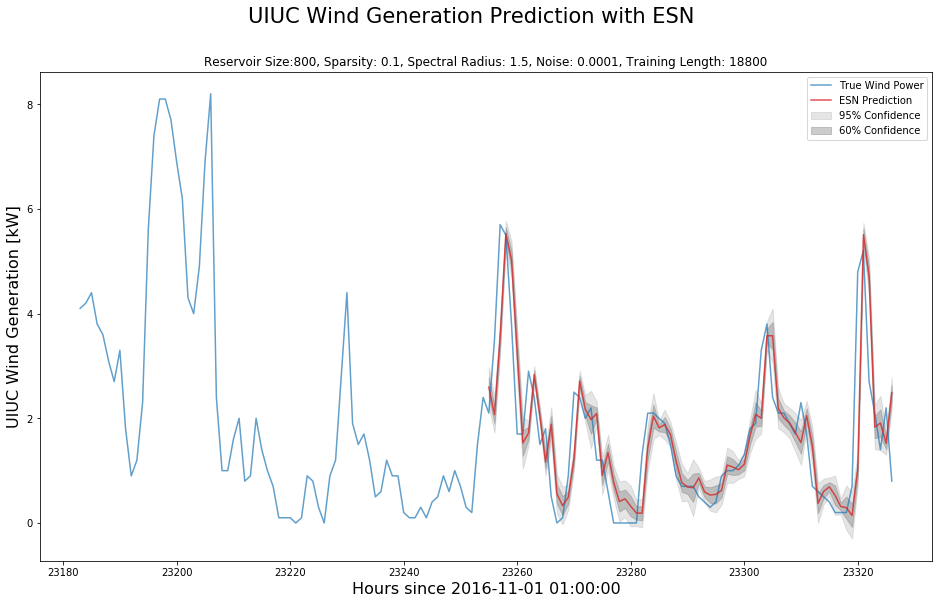

In [27]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Generation Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Wind Generation [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()